# European Credit Card Fraud Detection

According to recent [Nilson Report](https://nilsonreport.com/#), \\$28.6 billion was lost to fraud worldwide in 2020; and is expected to reach \\$408.5 billion globally within the next decade. Hence, credit card fraud detection has become more important than ever.

<img align="left" src="https://images.idgesg.net/images/article/2020/07/credit_card_theft_credit_card_fraud_credit_card_hack_by_jariyawat_thinsandee_gettyimages-1156955640_2400x1600-100852255-large.jpg?auto=webp&quality=85,70" width="500"> 

## About Dataset

[Kaggle dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) contains transactions made by credit cards in September 2013 by European cardholders:
* Total of 492 frauds out of 284,807 transactions (0.172% of all transactions)
* Only numerical input variables (28) as a result of PCA transformation due to confidentiality issues
* Only 'Time' and 'Amount' have not been transformed
    * 'Time': Seconds elapsed between each transaction and first transaction in dataset
    * 'Amount': transaction amount
* 'Class' is the response variable and takes value `1` in case of fraud and `0` otherwise

## Note:
* There are **multiple entries for the same time step**, which are likely due to card transactions by different cardholders at the same time
* **Credit card transactions do not occur at fixed time step interval**
* We will generate 16 different permutations of the dataset to test out our models:
    * Keep our features i.e. Time, V1-V28, and Amount
    * Keep only PCA components i.e. V1-V28 as per [Using Variational Auto Encoding in Credit
Card Fraud Detection](https://ieeexplore.ieee.org/document/9163376)
    * Remove duplicates by keeping only the first occurence of duplicates
    * Remove duplicates by keeping only the last occurence of duplicates
    * Remove duplicates by keeping only the first instance of duplicates that is an anomaly i.e. attack = 1
    * Remove duplicates by taking mean of duplicates
    * Remove duplicates by taking median of duplicates
    * Over-sample minority class via Adasyn
    * Apply min-max scaling and standard scaling on the above 8 datasets to generate total of 16 variations of credit card dataset.

# Pre-processing

1. Calculate time interval between each consecutive time step
2. Check for missing and erroneous data
3. Apply Min-Max scaling on all columns except for 'Class'
4. Assign first 70% of dataset (i.e. record 1 to 199,365) as train set and save as train.csv
5. Assign remaining 30% as test set (i.e. record 199,366 to 284807) and save as test.csv

## Load Libraries

In [1]:
# load libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

## Define Function

In [2]:
def get_stat(df):
    """
    Compute min, max, mean and median for credit dataset.
    Save results as stat.csv under credit folder.
    """
    # Get min, max, mean and median from df.describe()
    stat = df.describe().T.get(['min', 'max', 'mean', '50%'])

    # Rename column and change to title casing
    stat = stat.reset_index(level=0).rename(columns={'index': 'column', '50%':'median'})
    stat = stat.rename(columns=str.title)

    # Insert 'S/N' column as first column
    stat.insert(0, 'S/N', [i+1 for i in range(len(stat))])

    # Save as credit_stat.csv in credit folder
    stat.to_csv('./credit/credit_stat.csv', index=False)
    
    return stat



def split_data(df, split=70):
    """
    Split df by assigned percentage and assign as train data
    Remaining assign as test data
    """
    
    lastrow = round(df.shape[0]*split/100)
    df_train = df[:lastrow]
    df_test = df[lastrow:].reset_index(drop=True)
    
    return df_train, df_test



def record_changed(df_ori, train, test):
    """
    Compute number of duplicates removed and percentage reduced
    or number of synthetic records added and percentage increased
    """
    
    ori = len(df_ori)
    new = len(train) + len(test)
    changed = new - ori
    percent_changed = round(changed/ori*100,2)

    if changed <= 0:
        print(f"{'Number of duplicates removed':<30} : {abs(changed)}")
        print(f"{'Percentage reduction':<30} : {abs(percent_changed)}%")
    else:
        print(f"{'Number of synthetic samples added':<40} : {changed}")
        print(f"{'Percentage added':<40} : {percent_changed}%")
    
    return [changed, str(percent_changed)+'%']



def scaling(dframe:object, choice:str ='standard') -> object:
    """
    Perform standard or min max scaling of features other than Time and Class. Rename Class to attack
    """

    # Drop 'Time', 'Class' and 'Interval' column prior to Min-Max Scaling
    scaled_col = [col for col in dframe.columns if col != 'Class' and col != 'Time' and col != 'Interval']
    df_scaled = dframe[scaled_col]

    # Apply scaling except on 'Time', 'Class' and 'Interval'
    if choice == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
        
    np_scaled = scaler.fit_transform(df_scaled)

    # Convert to dataframe
    df_scaled = pd.DataFrame(np_scaled, columns=scaled_col)
    
    # Append 'Time' and 'Class'
    df_processed = pd.concat([dframe['Time'], df_scaled, dframe['Class']], axis=1)
    df_processed.rename(columns={'Class':'attack'}, inplace=True)
    
    return df_processed



def list_text(col_names: list, file_path: str):
    """
    Save column names, which will be used as features for models, in list.txt
    """
    
    # Write file
    f = open(file_path, 'w')
    
    if 'Time' not in col_names and 'Amount' not in col_names:
        for i in range(len(col_names)-1):
            if col_names[i] == 'V28':                  # Do not append new line if Last column is 'V28'
                f.write(col_names[i])
            else:
                f.write(col_names[i]+'\n')
    else:
        for i in range(1, len(col_names)-1):
            if col_names[i] == 'Amount':               # Do not append new line if last column is 'Amount'
                f.write(col_names[i])
            else:
                f.write(col_names[i]+'\n')
    
    f.close()



def dup_method(dup:list, new_list:list, dframe:object, choice:str) -> list:
    """
    Calculate mean, median, first (index 0), last (index -1) or time step with anomaly i.e. attack = 1 
    """
    
    choice = choice.lower()
    df_dup = pd.DataFrame(dup, columns=dframe.columns).reset_index(drop=True)
    
    if choice == 'mean':
        # Set 'attack' to 1 if any one of duplicated time stamp is an anomaly
        df_dup['attack'] = df_dup['attack'].max()
        new_list.append(df_dup.mean(axis=0))

    elif choice == 'median':
        # Set 'attack' to 1 if any one of duplicated time stamp is an anomaly
        df_dup['attack'] = df_dup['attack'].max()
        new_list.append(df_dup.median(axis=0))

    elif choice == 'anomaly':
        
        # Select rows that contain anomaly i.e. 'attack' = 1
        df_anomaly = df_dup.loc[df_dup['attack']==1,:].reset_index(drop=True)
        
        # Append 1st instance of duplicated time stamp if no anomaly
        # Append 1st instance of anomaly if multiple anomalies
        
        if len(df_anomaly) == 0:
            new_list.append(dup[0])     
        else:
            new_list.append(df_anomaly.loc[0,:])      

    else:
        # User can select first row i.e. choice = 0 or last row i.e. choice = -1
        new_list.append(dup[int(choice)])
    
    return new_list



def remove_dup(dframe: object, choice: str ='mean') -> object:
    """
    Replace duplicate either with mean, median, anomaly, first or last item in duplicated time steps
    """
    
    new_list, dup = [], []
    t = dframe['Time']
    
    for i in range(1, len(dframe)):
        # At beginning of dataset
        if i == 1:
            if t[i] == t[i-1]:
                dup.extend([dframe.loc[0,:], dframe.loc[1,:]])
            else:
                new_list.append(dframe.loc[0,:])
        
        # At end of dataset
        elif i == len(dframe)-1:
            if t[i] == t[i-1] == t[i-2]:
                dup.append(dframe.loc[i,:])
                new_list = dup_method(dup, new_list, dframe, choice)
                
            elif t[i] == t[i-1] and t[i-1] != t[i-2]:
                dup.extend([dframe.loc[i-1,:], dframe.loc[i,:]])
                new_list = dup_method(dup, new_list, dframe, choice)
                
            elif t[i] != t[i-1]:
                if dup:
                    new_list = dup_method(dup, new_list, dframe, choice)
                    new_list.append(dframe.loc[i,:])
                else:
                    new_list.extend([dframe.loc[i-1,:], dframe.loc[i,:]])   
        
        # Whether current item is same or different from previous 2 items
        else:
            if t[i] == t[i-1] == t[i-2]:
                dup.append(dframe.loc[i,:])
                
            elif t[i] == t[i-1] and t[i-1] != t[i-2]:
                dup.extend([dframe.loc[i-1,:], dframe.loc[i,:]])
                
            elif t[i] != t[i-1]:
                if dup:
                    new_list = dup_method(dup, new_list, dframe, choice)
                    dup = []
                    
                else:
                    new_list.append(dframe.loc[i-1,:])
    
    
    df_new = pd.DataFrame(new_list, columns=dframe.columns).reset_index(drop=True)          
    df_new['attack'] = df_new['attack'].astype('int64')
    
    return df_new



def under_sample(df, dataset, percent=70):
    """
    Split dataset according to assigned percentage into train and test.
    Scaled train and test according to dataset name ('_s': standard scaling else min-max scaling)
    Under_sample based either all, pca, first, last, anomaly, mean or median.
    Save result as csv under folder having same name as dataset.
    """
    
    # Split dataset into train and test followed by scaling
    df_train_scaled, df_test_scaled = prepare(df, dataset, percent)
        
    # Sample dataset according to name of dataset
    if dataset.startswith('all'):
        df_train_sampled = df_train_scaled
        df_test_sampled = df_test_scaled
        
    elif dataset.startswith('pca'):       
        df_train_sampled = df_train_scaled.drop(columns=['Time', 'Amount'])
        df_test_sampled = df_test_scaled.drop(columns=['Time', 'Amount'])
        
    elif dataset.startswith('first'):
        df_train_sampled = remove_dup(df_train_scaled, '0')
        df_test_sampled = remove_dup(df_test_scaled, '0')

    elif dataset.startswith('last'):
        df_train_sampled = remove_dup(df_train_scaled, '-1')
        df_test_sampled = remove_dup(df_test_scaled, '-1')
        
    elif dataset.startswith('anomaly'):
        df_train_sampled = remove_dup(df_train_scaled, 'anomaly')
        df_test_sampled = remove_dup(df_test_scaled, 'anomaly')
       
    elif dataset.startswith('mean'):
        df_train_sampled = remove_dup(df_train_scaled, 'mean')
        df_test_sampled = remove_dup(df_test_scaled, 'mean')   
        
    elif dataset.startswith('median'):
        df_train_sampled = remove_dup(df_train_scaled, 'median')
        df_test_sampled = remove_dup(df_test_scaled, 'median')
        
    save_data(df_train_sampled, df_test_sampled, dataset)
    summary = [dataset]
    summary.extend(record_changed(df, df_train_sampled, df_test_sampled))
    summary.extend(norm_vs_anom(df_train_sampled, df_test_sampled))

    return df_train_sampled, df_test_sampled, summary



def prepare(df, dataset, percent):
    """
    Split data into train and test based on assigned percentage.  
    Normalized train and test data based on dataset.
    """
    
    # Split dataset
    df_train, df_test = split_data(df, percent)
          
    # Normalize train and test data separately according to dataset
    if dataset.endswith('_s'):
        df_train_scaled = scaling(df_train, 'standard')
        df_test_scaled = scaling(df_test, 'standard')
    else:
        df_train_scaled = scaling(df_train, 'min_max')
        df_test_scaled = scaling(df_test, 'min_max')
        
    return df_train_scaled, df_test_scaled



def save_data(df_train_sampled, df_test_sampled, dataset):
    """
    Save train.csv, test.csv and list.txt in respective folder.
    Display percentage reduction.
    """
    
    # Create subfolder, having same name as dataset, under processed folder
    directory = Path.cwd().joinpath('processed', dataset)
    if not directory.is_dir():
        directory.mkdir(parents=True, exist_ok=True)
    
    # Save data under folder having same name as dataset
    train_path = directory.joinpath('train.csv')
    test_path = directory.joinpath('test.csv')
    list_path = directory.joinpath('list.txt')
    
    df_train_sampled.to_csv(train_path, index=False)
    df_test_sampled.to_csv(test_path, index=False)
    
    # Save column names as list.txt   
    list_text(df_train_sampled.columns, list_path)
    
    

def over_sample(df, dataset, anom_percent, data_split=70):
    """
    Over-sample dataset via ADASYN and generate train.csv, test.csv and list.txt.
    Save generated files in folder having same name as dataset. 
    """
    
    # Separate dataset into features, X and label, y
    X = df.drop(columns=['Class'])
    y = df['Class']
    
    # Over-sample
    float_val = float(anom_percent / (100 - anom_percent))
    ada = ADASYN(sampling_strategy=float_val, random_state=5)
    X_res, y_res = ada.fit_resample(X, y)
    
    # Convert Time column to integer datatype
    X_res['Time'] = X_res['Time'].astype(int)

    # Round Amount column to 2 decimal places
    X_res['Amount'] = round(X_res['Amount'], 2)

    # Combine X_res and y_res to form re-sampled dataset
    df1 = pd.concat([X_res, y_res], axis=1)

    # Sort dataframe by Time column
    df_res = df1.sort_values(by=['Time']).reset_index(drop=True)
    
    # Split data and normalize based on dataset
    df_train_scaled, df_test_scaled = prepare(df_res, dataset, data_split)
    
    # Save data
    save_data(df_train_scaled, df_test_scaled, dataset)
    summary = [dataset]
    summary.extend(record_changed(df, df_train_scaled, df_test_scaled))
    summary.extend(norm_vs_anom(df_train_scaled, df_test_scaled))
    
    return df_train_scaled, df_test_scaled, df_res, summary



def norm_vs_anom(train, test):
    """
    Display number of normal and anomaly transactions for train and test dataset
    """
    data = [train, test]
    result = []
    
    # train_norm = result[0]
    # train_anom = result[1]
    # test_norm = result[2]
    # test_norm = result[3]
    
    for df in data:
        for i in range(2):
            result.append(df['attack'].value_counts()[i])
            
    return result




In [3]:
# Load creditcard.csv in credit folder
path = Path.cwd().joinpath('credit', 'creditcard.csv')
df = pd.read_csv(path, sep=',', header=0)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Missing data

In [4]:
# Check for missing values
df.isna().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Compute min, max, mean and median for credit dataset
stat = get_stat(df)
stat

,S/N,Column,Min,Max,Mean,Median
0,1,Time,0.000000,172792.000000,9.481386e+04,84692.000000
1,2,V1,-56.407510,2.454930,1.759061e-12,0.018109
2,3,V2,-72.715728,22.057729,-8.251130e-13,0.065486
3,4,V3,-48.325589,9.382558,-9.654937e-13,0.179846
4,5,V4,-5.683171,16.875344,8.321385e-13,-0.019847
5,6,V5,-113.743307,34.801666,1.649999e-13,-0.054336
6,7,V6,-26.160506,73.301626,4.248366e-13,-0.274187
7,8,V7,-43.557242,120.589494,-3.054600e-13,0.040103
8,9,V8,-73.216718,20.007208,8.777971e-14,0.022358
9,10,V9,-13.434066,15.594995,-1.179749e-12,-0.051429


#### Observations
* Total of 284,807 records and 31 columns, which consist of 'Time', 'Amount', 'Class' and 28 PCA components (i.e. V1 to V28)
* All 31 columns do not contain any missing value; and are all numeric (i.e. either integer or float type)

## Erroneous data

In [7]:
# Check 'Class' column i.e. labels
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
# Check whether min value is applicable
df.min().sort_values()

V5       -113.743307
V8        -73.216718
V2        -72.715728
V1        -56.407510
V20       -54.497720
V3        -48.325589
V23       -44.807735
V7        -43.557242
V21       -34.830382
V6        -26.160506
V17       -25.162799
V10       -24.588262
V27       -22.565679
V14       -19.214325
V12       -18.683715
V28       -15.430084
V16       -14.129855
V9        -13.434066
V22       -10.933144
V25       -10.295397
V18        -9.498746
V19        -7.213527
V13        -5.791881
V4         -5.683171
V11        -4.797473
V15        -4.498945
V24        -2.836627
V26        -2.604551
Time        0.000000
Amount      0.000000
Class       0.000000
dtype: float64

In [9]:
# Check whether max value is applicable
df.max().sort_values(ascending=False)

Time      172792.000000
Amount     25691.160000
V7           120.589494
V6            73.301626
V20           39.420904
V5            34.801666
V28           33.847808
V27           31.612198
V21           27.202839
V10           23.745136
V23           22.528412
V2            22.057729
V8            20.007208
V16           17.315112
V4            16.875344
V9            15.594995
V11           12.018913
V14           10.526766
V22           10.503090
V3             9.382558
V17            9.253526
V15            8.877742
V12            7.848392
V25            7.519589
V13            7.126883
V19            5.591971
V18            5.041069
V24            4.584549
V26            3.517346
V1             2.454930
Class          1.000000
dtype: float64

In [10]:
# Range of values for each column
df_range = df.max() - df.min()
df_range.sort_values(ascending=False)

Time      172792.000000
Amount     25691.160000
V7           164.146735
V5           148.544973
V6            99.462131
V2            94.773457
V20           93.918625
V8            93.223927
V23           67.336147
V21           62.033221
V1            58.862440
V3            57.708148
V27           54.177877
V28           49.277892
V10           48.333399
V17           34.416326
V16           31.444966
V14           29.741092
V9            29.029061
V12           26.532107
V4            22.558515
V22           21.436234
V25           17.814986
V11           16.816387
V18           14.539815
V15           13.376686
V13           12.918764
V19           12.805499
V24            7.421176
V26            6.121896
Class          1.000000
dtype: float64

#### Observations
* Label/Target i.e. 'Class' column contains only 2 values i.e `0` for normal and `1` for anomaly
* Range of values differs significantly between columns, which justify the need for min-max scaling to prevent models from placing excessive emphasis on certain PCA components (especially for 'Amount', 'V7' and 'V5')
* No negative values for 'Time' and 'Amount' column

## Time Interval

In [11]:
# Calculate time interval between consecutive step
df1 = df.copy()
df1.insert(1, 'Interval', [0 if i == 0 else int(df['Time'][i]-df['Time'][i-1]) for i in range(len(df))])
df1[:10]

,Time,Interval,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,1,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,2,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,2,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [12]:
# Analysis of time interval
df1['Interval'].value_counts()

0     160216
1     100059
2      15620
3       4156
4       1807
5        961
6        619
7        380
8        298
9        200
10       138
11        86
12        61
13        56
14        33
16        26
15        23
17        14
19        12
18         9
20         7
21         5
26         4
22         4
32         4
28         3
25         2
24         2
27         1
23         1
Name: Interval, dtype: int64

#### Observations
* More than 50% of dataset are records having duplicate/identical timestamp (i.e. **160216**). Note that records that have the same time stamp (i.e. occurs at the same time) are different i.e. different values for each column
* Maximum time interval between consecutive records is 23 seconds.

In [13]:
# Save changed, percent_changed, train_norm, train_anom, test_norm, test_anom for each of 16 credit datasets to list
summary = []

# <font color='red'>All Features</font>
* Min-max and standard scaling of V1-V28; and Amount column

## 'all' dataset

In [14]:
# Min-max scaling
df_train_all, df_test_all, summary_all = under_sample(df, 'all')
summary.append(summary_all)
df_train_all

Number of duplicates removed   : 0
Percentage reduction           : 0.0%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.935192,0.766490,0.841021,0.313023,0.543337,0.546786,0.545860,0.786444,0.475312,...,0.561184,0.522992,0.700467,0.423290,0.585122,0.394557,0.653816,0.256589,0.007612,0
1,0.0,0.978542,0.770067,0.785989,0.271796,0.548514,0.535598,0.541892,0.786298,0.453981,...,0.557840,0.480237,0.703785,0.363989,0.587290,0.446013,0.649710,0.257374,0.000137,0
2,1.0,0.935217,0.753118,0.823300,0.268766,0.541195,0.574268,0.552739,0.788042,0.410603,...,0.565477,0.546030,0.716450,0.313047,0.559515,0.402727,0.648375,0.255739,0.019264,0
3,1.0,0.941878,0.765304,0.823759,0.213661,0.547600,0.562904,0.545836,0.789434,0.414999,...,0.559734,0.510277,0.699216,0.242154,0.614245,0.389197,0.651776,0.258400,0.006283,0
4,2.0,0.938617,0.776520,0.818086,0.269796,0.542442,0.539259,0.550264,0.782484,0.490950,...,0.561327,0.547271,0.700044,0.434127,0.566343,0.507497,0.656289,0.261773,0.003561,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199360,132927.0,0.990934,0.771429,0.728280,0.313923,0.561159,0.524087,0.550722,0.783114,0.456627,...,0.562091,0.520214,0.701720,0.499482,0.602721,0.336196,0.649695,0.256486,0.002058,0
199361,132927.0,0.947447,0.767860,0.805858,0.195740,0.555188,0.542506,0.538490,0.787822,0.408954,...,0.566504,0.546769,0.695411,0.437032,0.611107,0.457078,0.652052,0.259251,0.001119,0
199362,132928.0,0.934788,0.707829,0.674440,0.312399,0.547179,0.562082,0.578861,0.780909,0.453882,...,0.584289,0.528486,0.678064,0.351807,0.559367,0.577340,0.638078,0.261361,0.088795,0
199363,132928.0,0.931276,0.779771,0.803712,0.232884,0.546528,0.525409,0.552153,0.786118,0.475031,...,0.565637,0.564112,0.693661,0.419892,0.640428,0.459587,0.646827,0.254277,0.002050,0


In [15]:
df_test_all

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.993930,0.784025,0.903765,0.218802,0.791641,0.213543,0.158749,0.783027,0.369066,...,0.511910,0.406570,0.625475,0.270825,0.556384,0.229070,0.237829,0.490425,0.002178,0
1,132929.0,0.987008,0.801847,0.935056,0.439331,0.794794,0.234051,0.156357,0.795759,0.343155,...,0.521290,0.491997,0.625599,0.467231,0.552928,0.309305,0.239181,0.491116,0.000031,0
2,132929.0,0.919348,0.789671,0.919142,0.222549,0.820595,0.202180,0.171988,0.771274,0.335227,...,0.525214,0.549640,0.604766,0.491093,0.647173,0.336613,0.232308,0.479791,0.001203,0
3,132930.0,0.952284,0.812127,0.917732,0.237146,0.801163,0.214930,0.167682,0.789952,0.381765,...,0.511405,0.415942,0.621374,0.460414,0.553123,0.369551,0.243407,0.494120,0.000069,0
4,132930.0,0.990948,0.795968,0.905162,0.282317,0.794671,0.211490,0.162806,0.784147,0.413286,...,0.513027,0.430547,0.625199,0.385769,0.564559,0.385009,0.236507,0.489619,0.000209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85437,172786.0,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
85438,172787.0,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
85439,172788.0,0.989204,0.793519,0.862489,0.239754,0.814341,0.253802,0.160370,0.801492,0.419543,...,0.524235,0.506899,0.618783,0.464090,0.606899,0.335418,0.238504,0.490992,0.002642,0
85440,172788.0,0.945397,0.806697,0.938110,0.299551,0.793289,0.228237,0.157666,0.800911,0.416393,...,0.525032,0.521115,0.616658,0.393857,0.550363,0.455706,0.241019,0.495171,0.000389,0


## 'all_s' dataset

In [16]:
# Standard scaling
df_train_all_s, df_test_all_s, summary_all_s = under_sample(df, 'all_s')
summary.append(summary_all_s)
df_train_all_s

Number of duplicates removed   : 0
Percentage reduction           : 0.0%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,-0.663334,-0.047189,1.530570,0.930993,-0.166119,0.317630,0.238238,0.067417,0.312538,...,-0.004924,0.471202,-0.155472,0.103788,0.137861,-0.400014,0.334911,-0.073184,0.240443,0
1,0.0,0.686013,0.161799,-0.106605,0.266337,0.126448,-0.097892,-0.023162,0.056179,-0.232669,...,-0.285978,-0.854533,0.191251,-0.570144,0.216500,0.244982,-0.026825,0.040814,-0.349850,0
2,1.0,-0.662566,-0.828667,1.003372,0.217471,-0.287217,1.338312,0.691304,0.190563,-1.341400,...,0.355834,1.185546,1.514413,-1.149077,-0.790760,-0.297599,-0.144500,-0.196490,1.160613,0
3,1.0,-0.455228,-0.116524,1.017039,-0.670930,0.074795,0.916270,0.236604,0.297823,-1.229024,...,-0.126837,0.076937,-0.286207,-1.954755,1.194026,-0.467202,0.155148,0.189721,0.135505,0
4,2.0,-0.556739,0.538908,0.848286,0.234091,-0.216704,0.038098,0.528323,-0.237791,0.712236,...,0.007100,1.224022,-0.199654,0.226951,-0.543160,1.015673,0.552813,0.679443,-0.079472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199360,132927.0,1.071753,0.241398,-1.823429,0.945517,0.841091,-0.525397,0.558477,-0.189209,-0.165030,...,0.071255,0.385060,-0.024533,0.969677,0.776096,-1.131552,-0.028163,-0.088062,-0.198109,0
199361,132927.0,-0.281893,0.032853,0.484497,-0.959862,0.503614,0.158670,-0.247254,0.173618,-1.383550,...,0.442077,1.208481,-0.683743,0.259961,1.080209,0.383675,0.179454,0.313306,-0.272272,0
199362,132928.0,-0.675910,-3.475269,-3.425144,0.920943,0.051017,0.885738,2.412034,-0.359140,-0.235211,...,1.936663,0.641559,-2.496045,-0.708587,-0.796140,1.891150,-1.051731,0.619550,6.651505,0
199363,132928.0,-0.785228,0.728884,0.420661,-0.361017,0.014183,-0.476281,0.652765,0.042253,0.305352,...,0.369250,1.746219,-0.866495,0.065166,2.143537,0.415130,-0.280862,-0.408805,-0.198792,0


In [17]:
df_test_all_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.913335,-0.518971,-0.244804,-0.569168,-0.630414,-0.474834,-0.509400,-0.157582,-0.192584,...,-0.435950,-1.393025,0.493098,-1.265486,-0.603878,-1.355622,-0.046715,-0.109233,-0.115001,0
1,132929.0,0.749835,0.135688,0.919196,2.629126,-0.305858,0.930060,-0.780012,0.397235,-0.522514,...,0.103558,0.296470,0.504320,1.103115,-0.694953,-0.450414,0.085306,-0.049910,-0.333121,0
2,132929.0,-0.848280,-0.311573,0.327203,-0.514826,2.350259,-1.253251,0.988437,-0.669775,-0.623463,...,0.329208,1.436476,-1.381647,1.390889,1.789087,-0.142326,-0.585798,-1.022864,-0.214056,0
3,132930.0,-0.070342,0.513274,0.274771,-0.303129,0.349783,-0.379809,0.501217,0.144203,-0.030875,...,-0.464972,-1.207670,0.121800,1.020907,-0.689813,0.229288,0.497880,0.208199,-0.329206,0
4,132930.0,0.842901,-0.080291,-0.192826,0.351985,-0.318493,-0.615457,-0.050435,-0.108796,0.370489,...,-0.371669,-0.918837,0.468052,0.120710,-0.388388,0.403678,-0.175796,-0.178491,-0.315010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85437,172786.0,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,...,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,-0.333200,0
85438,172787.0,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,...,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,-0.238217,0
85439,172788.0,0.801708,-0.170239,-1.780239,-0.265311,1.706456,2.283137,-0.326003,0.647080,0.450149,...,0.272932,0.591196,-0.112727,1.065234,0.727580,-0.155804,0.019189,-0.060504,-0.067826,0
85440,172788.0,-0.233011,0.313833,1.032812,0.601916,-0.460776,0.531756,-0.631955,0.621771,0.410039,...,0.318740,0.872352,-0.305107,0.218247,-0.762574,1.201289,0.264681,0.298519,-0.296702,0


In [18]:
# 384 anomaly records in train.csv
df_train_all["attack"].value_counts()

0    198981
1       384
Name: attack, dtype: int64

In [19]:
# 108 anomaly records in test.csv
df_test_all["attack"].value_counts()

0    85334
1      108
Name: attack, dtype: int64

#### Note:
* Numerical features except 'Time' and 'Class' have been normalized to between 0 and 1
* Training dataset (**198,981 normal vs 384 fraud**) and test dataset (**85,334 normal vs 108 fraud**) have successfully been generated based on 70 to 30 ratio
* Anomaly data point will be removed from the Training set if the models required semi-supervised learning
<hr>

# <font color='red'>PCA Components</font>
* Remove Time and Amount column before normalizing only PCA components (i.e. V1-V28)

## 'pca' dataset

In [20]:
df_train_pca, df_test_pca, summary_pca = under_sample(df, 'pca')
summary.append(summary_pca)
df_train_pca

Number of duplicates removed   : 0
Percentage reduction           : 0.0%


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,attack
0,0.935192,0.766490,0.841021,0.313023,0.543337,0.546786,0.545860,0.786444,0.475312,0.510600,...,0.394067,0.561184,0.522992,0.700467,0.423290,0.585122,0.394557,0.653816,0.256589,0
1,0.978542,0.770067,0.785989,0.271796,0.548514,0.535598,0.541892,0.786298,0.453981,0.505267,...,0.389109,0.557840,0.480237,0.703785,0.363989,0.587290,0.446013,0.649710,0.257374,0
2,0.935217,0.753118,0.823300,0.268766,0.541195,0.574268,0.552739,0.788042,0.410603,0.513018,...,0.398299,0.565477,0.546030,0.716450,0.313047,0.559515,0.402727,0.648375,0.255739,0
3,0.941878,0.765304,0.823759,0.213661,0.547600,0.562904,0.545836,0.789434,0.414999,0.507585,...,0.386959,0.559734,0.510277,0.699216,0.242154,0.614245,0.389197,0.651776,0.258400,0
4,0.938617,0.776520,0.818086,0.269796,0.542442,0.539259,0.550264,0.782484,0.490950,0.524303,...,0.396498,0.561327,0.547271,0.700044,0.434127,0.566343,0.507497,0.656289,0.261773,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199360,0.990934,0.771429,0.728280,0.313923,0.561159,0.524087,0.550722,0.783114,0.456627,0.504271,...,0.388109,0.562091,0.520214,0.701720,0.499482,0.602721,0.336196,0.649695,0.256486,0
199361,0.947447,0.767860,0.805858,0.195740,0.555188,0.542506,0.538490,0.787822,0.408954,0.499451,...,0.398561,0.566504,0.546769,0.695411,0.437032,0.611107,0.457078,0.652052,0.259251,0
199362,0.934788,0.707829,0.674440,0.312399,0.547179,0.562082,0.578861,0.780909,0.453882,0.493028,...,0.439090,0.584289,0.528486,0.678064,0.351807,0.559367,0.577340,0.638078,0.261361,0
199363,0.931276,0.779771,0.803712,0.232884,0.546528,0.525409,0.552153,0.786118,0.475031,0.504071,...,0.390598,0.565637,0.564112,0.693661,0.419892,0.640428,0.459587,0.646827,0.254277,0


In [21]:
df_test_pca

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,attack
0,0.993930,0.784025,0.903765,0.218802,0.791641,0.213543,0.158749,0.783027,0.369066,0.521998,...,0.698204,0.511910,0.406570,0.625475,0.270825,0.556384,0.229070,0.237829,0.490425,0
1,0.987008,0.801847,0.935056,0.439331,0.794794,0.234051,0.156357,0.795759,0.343155,0.552569,...,0.694885,0.521290,0.491997,0.625599,0.467231,0.552928,0.309305,0.239181,0.491116,0
2,0.919348,0.789671,0.919142,0.222549,0.820595,0.202180,0.171988,0.771274,0.335227,0.488467,...,0.694744,0.525214,0.549640,0.604766,0.491093,0.647173,0.336613,0.232308,0.479791,0
3,0.952284,0.812127,0.917732,0.237146,0.801163,0.214930,0.167682,0.789952,0.381765,0.466308,...,0.696267,0.511405,0.415942,0.621374,0.460414,0.553123,0.369551,0.243407,0.494120,0
4,0.990948,0.795968,0.905162,0.282317,0.794671,0.211490,0.162806,0.784147,0.413286,0.501874,...,0.694333,0.513027,0.430547,0.625199,0.385769,0.564559,0.385009,0.236507,0.489619,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85437,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,0.669734,...,0.716313,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0
85438,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,0.451474,...,0.698190,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0
85439,0.989204,0.793519,0.862489,0.239754,0.814341,0.253802,0.160370,0.801492,0.419543,0.471579,...,0.697445,0.524235,0.506899,0.618783,0.464090,0.606899,0.335418,0.238504,0.490992,0
85440,0.945397,0.806697,0.938110,0.299551,0.793289,0.228237,0.157666,0.800911,0.416393,0.475085,...,0.699058,0.525032,0.521115,0.616658,0.393857,0.550363,0.455706,0.241019,0.495171,0


## 'pca_s' dataset

In [22]:
df_train_pca_s, df_test_pca_s, summary_pca_s = under_sample(df, 'pca_s')
summary.append(summary_pca_s)
df_train_pca_s

Number of duplicates removed   : 0
Percentage reduction           : 0.0%


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,attack
0,-0.663334,-0.047189,1.530570,0.930993,-0.166119,0.317630,0.238238,0.067417,0.312538,0.093381,...,0.309042,-0.004924,0.471202,-0.155472,0.103788,0.137861,-0.400014,0.334911,-0.073184,0
1,0.686013,0.161799,-0.106605,0.266337,0.126448,-0.097892,-0.023162,0.056179,-0.232669,-0.142521,...,-0.118732,-0.285978,-0.854533,0.191251,-0.570144,0.216500,0.244982,-0.026825,0.040814,0
2,-0.662566,-0.828667,1.003372,0.217471,-0.287217,1.338312,0.691304,0.190563,-1.341400,0.200318,...,0.674180,0.355834,1.185546,1.514413,-1.149077,-0.790760,-0.297599,-0.144500,-0.196490,0
3,-0.455228,-0.116524,1.017039,-0.670930,0.074795,0.916270,0.236604,0.297823,-1.229024,-0.040001,...,-0.304198,-0.126837,0.076937,-0.286207,-1.954755,1.194026,-0.467202,0.155148,0.189721,0
4,-0.556739,0.538908,0.848286,0.234091,-0.216704,0.038098,0.528323,-0.237791,0.712236,0.699480,...,0.518768,0.007100,1.224022,-0.199654,0.226951,-0.543160,1.015673,0.552813,0.679443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199360,1.071753,0.241398,-1.823429,0.945517,0.841091,-0.525397,0.558477,-0.189209,-0.165030,-0.186600,...,-0.205034,0.071255,0.385060,-0.024533,0.969677,0.776096,-1.131552,-0.028163,-0.088062,0
199361,-0.281893,0.032853,0.484497,-0.959862,0.503614,0.158670,-0.247254,0.173618,-1.383550,-0.399818,...,0.696844,0.442077,1.208481,-0.683743,0.259961,1.080209,0.383675,0.179454,0.313306,0
199362,-0.675910,-3.475269,-3.425144,0.920943,0.051017,0.885738,2.412034,-0.359140,-0.235211,-0.683904,...,4.193677,1.936663,0.641559,-2.496045,-0.708587,-0.796140,1.891150,-1.051731,0.619550,0
199363,-0.785228,0.728884,0.420661,-0.361017,0.014183,-0.476281,0.652765,0.042253,0.305352,-0.195448,...,0.009719,0.369250,1.746219,-0.866495,0.065166,2.143537,0.415130,-0.280862,-0.408805,0


In [23]:
df_test_pca_s

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,attack
0,0.913335,-0.518971,-0.244804,-0.569168,-0.630414,-0.474834,-0.509400,-0.157582,-0.192584,0.667738,...,0.130997,-0.435950,-1.393025,0.493098,-1.265486,-0.603878,-1.355622,-0.046715,-0.109233,0
1,0.749835,0.135688,0.919196,2.629126,-0.305858,0.930060,-0.780012,0.397235,-0.522514,1.359680,...,-0.186242,0.103558,0.296470,0.504320,1.103115,-0.694953,-0.450414,0.085306,-0.049910,0
2,-0.848280,-0.311573,0.327203,-0.514826,2.350259,-1.253251,0.988437,-0.669775,-0.623463,-0.091186,...,-0.199760,0.329208,1.436476,-1.381647,1.390889,1.789087,-0.142326,-0.585798,-1.022864,0
3,-0.070342,0.513274,0.274771,-0.303129,0.349783,-0.379809,0.501217,0.144203,-0.030875,-0.592724,...,-0.054173,-0.464972,-1.207670,0.121800,1.020907,-0.689813,0.229288,0.497880,0.208199,0
4,0.842901,-0.080291,-0.192826,0.351985,-0.318493,-0.615457,-0.050435,-0.108796,0.370489,0.212262,...,-0.239015,-0.371669,-0.918837,0.468052,0.120710,-0.388388,0.403678,-0.175796,-0.178491,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85437,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,4.011559,...,1.862103,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,0
85438,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,-0.928472,...,0.129652,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,0
85439,0.801708,-0.170239,-1.780239,-0.265311,1.706456,2.283137,-0.326003,0.647080,0.450149,-0.473441,...,0.058432,0.272932,0.591196,-0.112727,1.065234,0.727580,-0.155804,0.019189,-0.060504,0
85440,-0.233011,0.313833,1.032812,0.601916,-0.460776,0.531756,-0.631955,0.621771,0.410039,-0.394083,...,0.212613,0.318740,0.872352,-0.305107,0.218247,-0.762574,1.201289,0.264681,0.298519,0


In [24]:
df_train_pca['attack'].value_counts()

0    198981
1       384
Name: attack, dtype: int64

In [25]:
df_test_pca['attack'].value_counts()

0    85334
1      108
Name: attack, dtype: int64

#### Note:
* Only normalized PCA components (i.e. V1-V28) are captured in dataset
* Similar to all features, training dataset (**198,981 normal vs 384 fraud**) and test dataset (**85,334 normal vs 108 fraud**) have successfully been generated based on 70 to 30 ratio
<hr>

# <font color='red'>Duplicates</font>
* Keep only 1st instance of duplicated time stamps
* Keep only last instance of duplicated time stamps
* Keep instance of duplicated time stamps that is labelled as anomaly
* Take mean of duplicated time stamps
* Take median of duplicate time stamps

# <font color='red'>First Instance</font>

## 'first' dataset

In [26]:
# min_max scaling
df_train_first, df_test_first, summary_first = under_sample(df, 'first')
summary.append(summary_first)
df_train_first

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.935192,0.766490,0.841021,0.313023,0.543337,0.546786,0.545860,0.786444,0.475312,...,0.561184,0.522992,0.700467,0.423290,0.585122,0.394557,0.653816,0.256589,0.007612,0
1,1.0,0.935217,0.753118,0.823300,0.268766,0.541195,0.574268,0.552739,0.788042,0.410603,...,0.565477,0.546030,0.716450,0.313047,0.559515,0.402727,0.648375,0.255739,0.019264,0
2,2.0,0.938617,0.776520,0.818086,0.269796,0.542442,0.539259,0.550264,0.782484,0.490950,...,0.561327,0.547271,0.700044,0.434127,0.566343,0.507497,0.656289,0.261773,0.003561,0
3,4.0,0.979184,0.768746,0.783177,0.305241,0.550228,0.542890,0.542810,0.786257,0.478797,...,0.558776,0.497402,0.699783,0.299814,0.620014,0.383429,0.650963,0.257164,0.000254,0
4,7.0,0.947348,0.782220,0.807072,0.230111,0.560066,0.546082,0.556841,0.744539,0.483978,...,0.592809,0.462660,0.703099,0.318816,0.554597,0.417014,0.615206,0.233228,0.002076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.988293,0.760589,0.757144,0.310906,0.548119,0.546432,0.539803,0.785989,0.502012,...,0.565702,0.544655,0.699802,0.419707,0.592964,0.362235,0.650495,0.256587,0.006837,0
89841,132926.0,0.991169,0.769362,0.722745,0.317355,0.559807,0.520628,0.550585,0.782975,0.477210,...,0.560766,0.503346,0.701274,0.448909,0.602452,0.343210,0.649252,0.256637,0.003422,0
89842,132927.0,0.943149,0.767446,0.853605,0.264888,0.537227,0.584990,0.528348,0.782595,0.464744,...,0.568680,0.515024,0.696329,0.466327,0.608042,0.392099,0.660252,0.255485,0.001272,0
89843,132928.0,0.934788,0.707829,0.674440,0.312399,0.547179,0.562082,0.578861,0.780909,0.453882,...,0.584289,0.528486,0.678064,0.351807,0.559367,0.577340,0.638078,0.261361,0.088795,0


In [27]:
# Check if all time stamps has only 1 unique occurence
all(df_train_first['Time'].value_counts()==1)

True

In [28]:
df_test_first

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.993930,0.784025,0.903765,0.218802,0.791641,0.213543,0.158749,0.783027,0.369066,...,0.511910,0.406570,0.625475,0.270825,0.556384,0.229070,0.237829,0.490425,0.002178,0
1,132930.0,0.952284,0.812127,0.917732,0.237146,0.801163,0.214930,0.167682,0.789952,0.381765,...,0.511405,0.415942,0.621374,0.460414,0.553123,0.369551,0.243407,0.494120,0.000069,0
2,132931.0,0.949448,0.818878,0.899015,0.297729,0.804338,0.219578,0.170056,0.792292,0.284088,...,0.527912,0.532950,0.619496,0.406770,0.536944,0.247571,0.241799,0.498347,0.001475,0
3,132932.0,0.982843,0.791565,0.868126,0.308566,0.809792,0.237083,0.167683,0.792220,0.354815,...,0.531129,0.557201,0.614868,0.224277,0.624835,0.332848,0.237690,0.489413,0.006422,0
4,132933.0,0.949798,0.815052,0.914758,0.238033,0.803771,0.213830,0.169280,0.784021,0.380669,...,0.510609,0.417956,0.621795,0.429685,0.564414,0.373505,0.240826,0.494183,0.000050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,0.952713,0.813043,0.914221,0.230778,0.803843,0.219108,0.168076,0.789720,0.369873,...,0.511130,0.418024,0.620267,0.391085,0.559388,0.375534,0.243647,0.494032,0.000105,0
34744,172786.0,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
34745,172787.0,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
34746,172788.0,0.989204,0.793519,0.862489,0.239754,0.814341,0.253802,0.160370,0.801492,0.419543,...,0.524235,0.506899,0.618783,0.464090,0.606899,0.335418,0.238504,0.490992,0.002642,0


In [29]:
# Check if all time stamps has only 1 unique occurence
all(df_test_first['Time'].value_counts()==1)

True

## 'first_all_s' dataset

In [30]:
# Standard scaling
df_train_first_s, df_test_first_s, summary_first_s = under_sample(df, 'first_s')
summary.append(summary_first_s)
df_train_first_s

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,-0.663334,-0.047189,1.530570,0.930993,-0.166119,0.317630,0.238238,0.067417,0.312538,...,-0.004924,0.471202,-0.155472,0.103788,0.137861,-0.400014,0.334911,-0.073184,0.240443,0
1,1.0,-0.662566,-0.828667,1.003372,0.217471,-0.287217,1.338312,0.691304,0.190563,-1.341400,...,0.355834,1.185546,1.514413,-1.149077,-0.790760,-0.297599,-0.144500,-0.196490,1.160613,0
2,2.0,-0.556739,0.538908,0.848286,0.234091,-0.216704,0.038098,0.528323,-0.237791,0.712236,...,0.007100,1.224022,-0.199654,0.226951,-0.543160,1.015673,0.552813,0.679443,-0.079472,0
3,4.0,0.706002,0.084632,-0.190271,0.805536,0.223298,0.172947,0.037298,0.052964,0.401619,...,-0.207326,-0.322274,-0.226908,-1.299469,1.403211,-0.539497,0.083544,0.010364,-0.340610,0
4,7.0,-0.284950,0.872017,0.520600,-0.405717,0.779330,0.291490,0.961545,-3.161766,0.534057,...,2.652653,-1.399551,0.119562,-1.083515,-0.969132,-0.118516,-3.066900,-3.464332,-0.196743,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.989525,-0.392057,-0.964715,0.896873,0.104138,0.304493,-0.160785,0.032363,0.994983,...,0.374745,1.142923,-0.224972,0.063067,0.422263,-0.805164,0.042304,-0.073450,0.179296,0
89841,132926.0,1.079049,0.120594,-1.988088,1.000834,0.764682,-0.653870,0.549422,-0.199924,0.361060,...,-0.040043,-0.137972,-0.071189,0.394940,0.766323,-1.043634,-0.067245,-0.066214,-0.090440,0
89842,132927.0,-0.415680,0.008669,1.904957,0.154957,-0.511454,1.736529,-0.915295,-0.229237,0.042435,...,0.624982,0.224118,-0.587816,0.592889,0.969073,-0.430818,0.901978,-0.233343,-0.260220,0
89843,132928.0,-0.675910,-3.475269,-3.425144,0.920943,0.051017,0.885738,2.412034,-0.359140,-0.235211,...,1.936663,0.641559,-2.496045,-0.708587,-0.796140,1.891150,-1.051731,0.619550,6.651505,0


In [31]:
# Check if all time stamps has only 1 unique occurence
all(df_train_first_s['Time'].value_counts()==1)

True

In [32]:
df_test_first_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.913335,-0.518971,-0.244804,-0.569168,-0.630414,-0.474834,-0.509400,-0.157582,-0.192584,...,-0.435950,-1.393025,0.493098,-1.265486,-0.603878,-1.355622,-0.046715,-0.109233,-0.115001,0
1,132930.0,-0.070342,0.513274,0.274771,-0.303129,0.349783,-0.379809,0.501217,0.144203,-0.030875,...,-0.464972,-1.207670,0.121800,1.020907,-0.689813,0.229288,0.497880,0.208199,-0.329206,0
2,132931.0,-0.137309,0.761249,-0.421480,0.575489,0.676666,-0.061406,0.769827,0.246168,-1.274621,...,0.484410,1.106411,-0.048188,0.373967,-1.116251,-1.146894,0.340860,0.571379,-0.186376,0
3,132932.0,0.651467,-0.241996,-1.570545,0.732662,1.238171,1.137751,0.501419,0.243000,-0.374044,...,0.669453,1.586021,-0.467151,-1.826844,1.200320,-0.184799,-0.060341,-0.196205,0.316218,0
4,132933.0,-0.129045,0.620736,0.164147,-0.290257,0.618286,-0.455166,0.682025,-0.114295,-0.044830,...,-0.510781,-1.167846,0.159894,0.650325,-0.392211,0.273895,0.245920,0.213606,-0.331144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,-0.060196,0.546938,0.144142,-0.395482,0.625748,-0.093621,0.545875,0.134086,-0.182297,...,-0.480764,-1.166503,0.021612,0.184812,-0.524678,0.296781,0.521354,0.200668,-0.325608,0
34744,172786.0,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,...,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,-0.333200,0
34745,172787.0,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,...,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,-0.238217,0
34746,172788.0,0.801708,-0.170239,-1.780239,-0.265311,1.706456,2.283137,-0.326003,0.647080,0.450149,...,0.272932,0.591196,-0.112727,1.065234,0.727580,-0.155804,0.019189,-0.060504,-0.067826,0


In [33]:
# Check if all time stamps has only 1 unique occurence
all(df_test_first_s['Time'].value_counts()==1)

True

In [34]:
# Normal vs anomaly for train data
df_train_first['attack'].value_counts()

0    89641
1      204
Name: attack, dtype: int64

In [35]:
# Normal vs anomaly for train data
df_test_first['attack'].value_counts()

0    34708
1       40
Name: attack, dtype: int64

#### Note
* Only retain first instance of duplicated time stamps 
* Training dataset (**89641 normal vs 204 fraud**) and test dataset (**34708 normal vs 40 fraud**) have successfully been generated based on 70 to 30 ratio
<hr>

# <font color='red'>Last Instance</font>

## 'last' dataset

In [36]:
# Min-max scaling
df_train_last, df_test_last, summary_last = under_sample(df, 'last')
summary.append(summary_last)
df_train_last

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.978542,0.770067,0.785989,0.271796,0.548514,0.535598,0.541892,0.786298,0.453981,...,0.557840,0.480237,0.703785,0.363989,0.587290,0.446013,0.649710,0.257374,0.000137,0
1,1.0,0.941878,0.765304,0.823759,0.213661,0.547600,0.562904,0.545836,0.789434,0.414999,...,0.559734,0.510277,0.699216,0.242154,0.614245,0.389197,0.651776,0.258400,0.006283,0
2,2.0,0.951057,0.777393,0.808621,0.244472,0.553205,0.536679,0.548809,0.788178,0.443190,...,0.558122,0.483915,0.701784,0.359385,0.564839,0.442749,0.657281,0.258830,0.000187,0
3,4.0,0.979184,0.768746,0.783177,0.305241,0.550228,0.542890,0.542810,0.786257,0.478797,...,0.558776,0.497402,0.699783,0.299814,0.620014,0.383429,0.650963,0.257164,0.000254,0
4,7.0,0.943101,0.770278,0.779494,0.239894,0.582427,0.613729,0.547487,0.794515,0.449275,...,0.560296,0.497525,0.698997,0.561006,0.598855,0.362697,0.650307,0.260176,0.004741,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.995534,0.767637,0.730475,0.231536,0.556405,0.508049,0.551937,0.778687,0.462216,...,0.561799,0.519536,0.701678,0.337638,0.589449,0.651764,0.645179,0.254955,0.000508,0
89841,132926.0,0.954912,0.769793,0.748061,0.221316,0.538023,0.560506,0.592350,0.773984,0.475985,...,0.557704,0.510636,0.708157,0.413869,0.520068,0.365407,0.651655,0.250826,0.030781,0
89842,132927.0,0.947447,0.767860,0.805858,0.195740,0.555188,0.542506,0.538490,0.787822,0.408954,...,0.566504,0.546769,0.695411,0.437032,0.611107,0.457078,0.652052,0.259251,0.001119,0
89843,132928.0,0.931276,0.779771,0.803712,0.232884,0.546528,0.525409,0.552153,0.786118,0.475031,...,0.565637,0.564112,0.693661,0.419892,0.640428,0.459587,0.646827,0.254277,0.002050,0


In [37]:
# Check if all time stamps has only 1 unique occurence
all(df_train_last['Time'].value_counts()==1)

True

In [38]:
df_test_last

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.919348,0.789671,0.919142,0.222549,0.820595,0.202180,0.171988,0.771274,0.335227,...,0.525214,0.549640,0.604766,0.491093,0.647173,0.336613,0.232308,0.479791,0.001203,0
1,132930.0,0.930540,0.803993,0.943417,0.225041,0.809068,0.213015,0.170249,0.779429,0.344359,...,0.524558,0.515564,0.610043,0.450979,0.668559,0.344980,0.233967,0.486736,0.000709,0
2,132931.0,0.993400,0.798807,0.881164,0.269854,0.802587,0.215780,0.166203,0.781792,0.380004,...,0.521286,0.499177,0.618194,0.414844,0.618597,0.483435,0.235453,0.488851,0.000030,0
3,132932.0,0.982843,0.791565,0.868126,0.308566,0.809792,0.237083,0.167683,0.792220,0.354815,...,0.531129,0.557201,0.614868,0.224277,0.624835,0.332848,0.237690,0.489413,0.006422,0
4,132933.0,0.949798,0.815052,0.914758,0.238033,0.803771,0.213830,0.169280,0.784021,0.380669,...,0.510609,0.417956,0.621795,0.429685,0.564414,0.373505,0.240826,0.494183,0.000050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,0.952713,0.813043,0.914221,0.230778,0.803843,0.219108,0.168076,0.789720,0.369873,...,0.511130,0.418024,0.620267,0.391085,0.559388,0.375534,0.243647,0.494032,0.000105,0
34744,172786.0,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
34745,172787.0,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
34746,172788.0,0.945397,0.806697,0.938110,0.299551,0.793289,0.228237,0.157666,0.800911,0.416393,...,0.525032,0.521115,0.616658,0.393857,0.550363,0.455706,0.241019,0.495171,0.000389,0


In [39]:
# Check if all time stamps has only 1 unique occurence
all(df_test_last['Time'].value_counts()==1)

True

## 'last_s' dataset

In [40]:
# Standard scaling
df_train_last_s, df_test_last_s, summary_last_s = under_sample(df, 'last_s')
summary.append(summary_last_s)
df_train_last_s

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.686013,0.161799,-0.106605,0.266337,0.126448,-0.097892,-0.023162,0.056179,-0.232669,...,-0.285978,-0.854533,0.191251,-0.570144,0.216500,0.244982,-0.026825,0.040814,-0.349850,0
1,1.0,-0.455228,-0.116524,1.017039,-0.670930,0.074795,0.916270,0.236604,0.297823,-1.229024,...,-0.126837,0.076937,-0.286207,-1.954755,1.194026,-0.467202,0.155148,0.189721,0.135505,0
2,2.0,-0.169509,0.589955,0.566698,-0.174198,0.391569,-0.057744,0.432483,0.201010,-0.508477,...,-0.262241,-0.740481,-0.017812,-0.622465,-0.597683,0.204073,0.640167,0.252245,-0.345913,0
3,4.0,0.706002,0.084632,-0.190271,0.805536,0.223298,0.172947,0.037298,0.052964,0.401619,...,-0.207326,-0.322274,-0.226908,-1.299469,1.403211,-0.539497,0.083544,0.010364,-0.340610,0
4,7.0,-0.417162,0.174135,-0.299811,-0.248006,2.043106,2.803850,0.345413,0.689344,-0.352962,...,-0.079592,-0.318487,-0.308986,1.668880,0.635912,-0.799372,0.025784,0.447643,0.013775,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,1.214922,0.019805,-1.758133,-0.382746,0.572436,-1.121046,0.638511,-0.530327,-0.022173,...,0.046714,0.364048,-0.028936,-0.869608,0.294777,2.824046,-0.426059,-0.310315,-0.320522,0
89841,132926.0,-0.049520,0.145803,-1.234957,-0.547520,-0.466494,0.827209,3.300541,-0.892749,0.329751,...,-0.297431,0.088076,0.648036,-0.003279,-2.221307,-0.765400,0.144491,-0.909709,2.070097,0
89842,132927.0,-0.281893,0.032853,0.484497,-0.959862,0.503614,0.158670,-0.247254,0.173618,-1.383550,...,0.442077,1.208481,-0.683743,0.259961,1.080209,0.383675,0.179454,0.313306,-0.272272,0
89843,132928.0,-0.785228,0.728884,0.420661,-0.361017,0.014183,-0.476281,0.652765,0.042253,0.305352,...,0.369250,1.746219,-0.866495,0.065166,2.143537,0.415130,-0.280862,-0.408805,-0.198792,0


In [41]:
# Check if all time stamps has only 1 unique occurence
all(df_train_last_s['Time'].value_counts()==1)

True

In [42]:
df_test_last_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,-0.848280,-0.311573,0.327203,-0.514826,2.350259,-1.253251,0.988437,-0.669775,-0.623463,...,0.329208,1.436476,-1.381647,1.390889,1.789087,-0.142326,-0.585798,-1.022864,-0.214056,0
1,132930.0,-0.583922,0.214510,1.230225,-0.478690,1.163635,-0.511002,0.791625,-0.314370,-0.507178,...,0.291487,0.762562,-0.903906,0.907121,2.352756,-0.047920,-0.423817,-0.426209,-0.264237,0
2,132931.0,0.900812,0.024020,-1.085531,0.171233,0.496438,-0.321585,0.333956,-0.211399,-0.053305,...,0.103307,0.438481,-0.166085,0.471337,1.035895,1.514122,-0.278665,-0.244459,-0.333240,0
3,132932.0,0.651467,-0.241996,-1.570545,0.732662,1.238171,1.137751,0.501419,0.243000,-0.374044,...,0.669453,1.586021,-0.467151,-1.826844,1.200320,-0.184799,-0.060341,-0.196205,0.316218,0
4,132933.0,-0.129045,0.620736,0.164147,-0.290257,0.618286,-0.455166,0.682025,-0.114295,-0.044830,...,-0.510781,-1.167846,0.159894,0.650325,-0.392211,0.273895,0.245920,0.213606,-0.331144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,-0.060196,0.546938,0.144142,-0.395482,0.625748,-0.093621,0.545875,0.134086,-0.182297,...,-0.480764,-1.166503,0.021612,0.184812,-0.524678,0.296781,0.521354,0.200668,-0.325608,0
34744,172786.0,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,...,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,-0.333200,0
34745,172787.0,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,...,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,-0.238217,0
34746,172788.0,-0.233011,0.313833,1.032812,0.601916,-0.460776,0.531756,-0.631955,0.621771,0.410039,...,0.318740,0.872352,-0.305107,0.218247,-0.762574,1.201289,0.264681,0.298519,-0.296702,0


In [43]:
# Check if all time stamps has only 1 unique occurence
all(df_test_last_s['Time'].value_counts()==1)

True

In [44]:
df_train_last['attack'].value_counts()

0    89645
1      200
Name: attack, dtype: int64

In [45]:
df_test_last['attack'].value_counts()

0    34702
1       46
Name: attack, dtype: int64

#### Note:
* Only retain last instance of duplicated time stamps 
* Training dataset (**89645 normal vs 200 fraud**) and test dataset (**34702 normal vs 46 fraud**) have successfully been generated based on 70 to 30 ratio
<hr>

# <font color='red'>Anomaly</font>

## 'anomaly' dataset

In [46]:
# Min-max scaling
df_train_anomaly, df_test_anomaly, summary_anomaly = under_sample(df, 'anomaly')
summary.append(summary_anomaly)
df_train_anomaly

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.935192,0.766490,0.841021,0.313023,0.543337,0.546786,0.545860,0.786444,0.475312,...,0.561184,0.522992,0.700467,0.423290,0.585122,0.394557,0.653816,0.256589,0.007612,0
1,1.0,0.935217,0.753118,0.823300,0.268766,0.541195,0.574268,0.552739,0.788042,0.410603,...,0.565477,0.546030,0.716450,0.313047,0.559515,0.402727,0.648375,0.255739,0.019264,0
2,2.0,0.938617,0.776520,0.818086,0.269796,0.542442,0.539259,0.550264,0.782484,0.490950,...,0.561327,0.547271,0.700044,0.434127,0.566343,0.507497,0.656289,0.261773,0.003561,0
3,4.0,0.979184,0.768746,0.783177,0.305241,0.550228,0.542890,0.542810,0.786257,0.478797,...,0.558776,0.497402,0.699783,0.299814,0.620014,0.383429,0.650963,0.257164,0.000254,0
4,7.0,0.947348,0.782220,0.807072,0.230111,0.560066,0.546082,0.556841,0.744539,0.483978,...,0.592809,0.462660,0.703099,0.318816,0.554597,0.417014,0.615206,0.233228,0.002076,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.988293,0.760589,0.757144,0.310906,0.548119,0.546432,0.539803,0.785989,0.502012,...,0.565702,0.544655,0.699802,0.419707,0.592964,0.362235,0.650495,0.256587,0.006837,0
89841,132926.0,0.991169,0.769362,0.722745,0.317355,0.559807,0.520628,0.550585,0.782975,0.477210,...,0.560766,0.503346,0.701274,0.448909,0.602452,0.343210,0.649252,0.256637,0.003422,0
89842,132927.0,0.943149,0.767446,0.853605,0.264888,0.537227,0.584990,0.528348,0.782595,0.464744,...,0.568680,0.515024,0.696329,0.466327,0.608042,0.392099,0.660252,0.255485,0.001272,0
89843,132928.0,0.934788,0.707829,0.674440,0.312399,0.547179,0.562082,0.578861,0.780909,0.453882,...,0.584289,0.528486,0.678064,0.351807,0.559367,0.577340,0.638078,0.261361,0.088795,0


In [47]:
# Check if all time stamps has only 1 unique occurence
all(df_train_anomaly['Time'].value_counts()==1)

True

In [48]:
df_test_anomaly

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.993930,0.784025,0.903765,0.218802,0.791641,0.213543,0.158749,0.783027,0.369066,...,0.511910,0.406570,0.625475,0.270825,0.556384,0.229070,0.237829,0.490425,0.002178,0
1,132930.0,0.952284,0.812127,0.917732,0.237146,0.801163,0.214930,0.167682,0.789952,0.381765,...,0.511405,0.415942,0.621374,0.460414,0.553123,0.369551,0.243407,0.494120,0.000069,0
2,132931.0,0.949448,0.818878,0.899015,0.297729,0.804338,0.219578,0.170056,0.792292,0.284088,...,0.527912,0.532950,0.619496,0.406770,0.536944,0.247571,0.241799,0.498347,0.001475,0
3,132932.0,0.982843,0.791565,0.868126,0.308566,0.809792,0.237083,0.167683,0.792220,0.354815,...,0.531129,0.557201,0.614868,0.224277,0.624835,0.332848,0.237690,0.489413,0.006422,0
4,132933.0,0.949798,0.815052,0.914758,0.238033,0.803771,0.213830,0.169280,0.784021,0.380669,...,0.510609,0.417956,0.621795,0.429685,0.564414,0.373505,0.240826,0.494183,0.000050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,0.952713,0.813043,0.914221,0.230778,0.803843,0.219108,0.168076,0.789720,0.369873,...,0.511130,0.418024,0.620267,0.391085,0.559388,0.375534,0.243647,0.494032,0.000105,0
34744,172786.0,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
34745,172787.0,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
34746,172788.0,0.989204,0.793519,0.862489,0.239754,0.814341,0.253802,0.160370,0.801492,0.419543,...,0.524235,0.506899,0.618783,0.464090,0.606899,0.335418,0.238504,0.490992,0.002642,0


In [49]:
# Check if all time stamps has only 1 unique occurence
all(df_test_anomaly['Time'].value_counts()==1)

True

In [50]:
# Standard scaling
df_train_anomaly_s, df_test_anomaly_s, summary_anomaly_s = under_sample(df, 'anomaly_s')
summary.append(summary_anomaly_s)
df_train_anomaly_s

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,-0.663334,-0.047189,1.530570,0.930993,-0.166119,0.317630,0.238238,0.067417,0.312538,...,-0.004924,0.471202,-0.155472,0.103788,0.137861,-0.400014,0.334911,-0.073184,0.240443,0
1,1.0,-0.662566,-0.828667,1.003372,0.217471,-0.287217,1.338312,0.691304,0.190563,-1.341400,...,0.355834,1.185546,1.514413,-1.149077,-0.790760,-0.297599,-0.144500,-0.196490,1.160613,0
2,2.0,-0.556739,0.538908,0.848286,0.234091,-0.216704,0.038098,0.528323,-0.237791,0.712236,...,0.007100,1.224022,-0.199654,0.226951,-0.543160,1.015673,0.552813,0.679443,-0.079472,0
3,4.0,0.706002,0.084632,-0.190271,0.805536,0.223298,0.172947,0.037298,0.052964,0.401619,...,-0.207326,-0.322274,-0.226908,-1.299469,1.403211,-0.539497,0.083544,0.010364,-0.340610,0
4,7.0,-0.284950,0.872017,0.520600,-0.405717,0.779330,0.291490,0.961545,-3.161766,0.534057,...,2.652653,-1.399551,0.119562,-1.083515,-0.969132,-0.118516,-3.066900,-3.464332,-0.196743,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.989525,-0.392057,-0.964715,0.896873,0.104138,0.304493,-0.160785,0.032363,0.994983,...,0.374745,1.142923,-0.224972,0.063067,0.422263,-0.805164,0.042304,-0.073450,0.179296,0
89841,132926.0,1.079049,0.120594,-1.988088,1.000834,0.764682,-0.653870,0.549422,-0.199924,0.361060,...,-0.040043,-0.137972,-0.071189,0.394940,0.766323,-1.043634,-0.067245,-0.066214,-0.090440,0
89842,132927.0,-0.415680,0.008669,1.904957,0.154957,-0.511454,1.736529,-0.915295,-0.229237,0.042435,...,0.624982,0.224118,-0.587816,0.592889,0.969073,-0.430818,0.901978,-0.233343,-0.260220,0
89843,132928.0,-0.675910,-3.475269,-3.425144,0.920943,0.051017,0.885738,2.412034,-0.359140,-0.235211,...,1.936663,0.641559,-2.496045,-0.708587,-0.796140,1.891150,-1.051731,0.619550,6.651505,0


In [51]:
# Check if all time stamps has only 1 unique occurence
all(df_train_anomaly_s['Time'].value_counts()==1)

True

In [52]:
df_test_anomaly_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.913335,-0.518971,-0.244804,-0.569168,-0.630414,-0.474834,-0.509400,-0.157582,-0.192584,...,-0.435950,-1.393025,0.493098,-1.265486,-0.603878,-1.355622,-0.046715,-0.109233,-0.115001,0
1,132930.0,-0.070342,0.513274,0.274771,-0.303129,0.349783,-0.379809,0.501217,0.144203,-0.030875,...,-0.464972,-1.207670,0.121800,1.020907,-0.689813,0.229288,0.497880,0.208199,-0.329206,0
2,132931.0,-0.137309,0.761249,-0.421480,0.575489,0.676666,-0.061406,0.769827,0.246168,-1.274621,...,0.484410,1.106411,-0.048188,0.373967,-1.116251,-1.146894,0.340860,0.571379,-0.186376,0
3,132932.0,0.651467,-0.241996,-1.570545,0.732662,1.238171,1.137751,0.501419,0.243000,-0.374044,...,0.669453,1.586021,-0.467151,-1.826844,1.200320,-0.184799,-0.060341,-0.196205,0.316218,0
4,132933.0,-0.129045,0.620736,0.164147,-0.290257,0.618286,-0.455166,0.682025,-0.114295,-0.044830,...,-0.510781,-1.167846,0.159894,0.650325,-0.392211,0.273895,0.245920,0.213606,-0.331144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,-0.060196,0.546938,0.144142,-0.395482,0.625748,-0.093621,0.545875,0.134086,-0.182297,...,-0.480764,-1.166503,0.021612,0.184812,-0.524678,0.296781,0.521354,0.200668,-0.325608,0
34744,172786.0,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,...,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,-0.333200,0
34745,172787.0,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,...,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,-0.238217,0
34746,172788.0,0.801708,-0.170239,-1.780239,-0.265311,1.706456,2.283137,-0.326003,0.647080,0.450149,...,0.272932,0.591196,-0.112727,1.065234,0.727580,-0.155804,0.019189,-0.060504,-0.067826,0


In [53]:
# Check if all time stamps has only 1 unique occurence
all(df_test_anomaly_s['Time'].value_counts()==1)

True

In [54]:
df_train_anomaly_s['attack'].value_counts()

0    89484
1      361
Name: attack, dtype: int64

In [55]:
df_test_anomaly_s['attack'].value_counts()

0    34641
1      107
Name: attack, dtype: int64

#### Note:
* Only retain first instance of duplicated time stamps that is an anomaly
* Training dataset (**89484 normal vs 361 fraud**) and test dataset (**34641 normal vs 107 fraud**) have successfully been generated based on 70 to 30 ratio
<hr>

# <font color='red'>Mean</font>

## 'mean' dataset

In [56]:
# Min-max scaling
df_train_mean, df_test_mean, summary_mean = under_sample(df, 'mean')
summary.append(summary_mean)
df_train_mean

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.956867,0.768279,0.813505,0.292410,0.545926,0.541192,0.543876,0.786371,0.464646,...,0.559512,0.501615,0.702126,0.393640,0.586206,0.420285,0.651763,0.256981,0.003874,0
1,1.0,0.938548,0.759211,0.823529,0.241213,0.544397,0.568586,0.549287,0.788738,0.412801,...,0.562605,0.528153,0.707833,0.277601,0.586880,0.395962,0.650075,0.257069,0.012773,0
2,2.0,0.944837,0.776957,0.813354,0.257134,0.547824,0.537969,0.549537,0.785331,0.467070,...,0.559725,0.515593,0.700914,0.396756,0.565591,0.475123,0.656785,0.260302,0.001874,0
3,4.0,0.979184,0.768746,0.783177,0.305241,0.550228,0.542890,0.542810,0.786257,0.478797,...,0.558776,0.497402,0.699783,0.299814,0.620014,0.383429,0.650963,0.257164,0.000254,0
4,7.0,0.945225,0.776249,0.793283,0.235003,0.571246,0.579905,0.552164,0.769527,0.466627,...,0.576552,0.480092,0.701048,0.439911,0.576726,0.389855,0.632757,0.246702,0.003409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.992850,0.761499,0.747534,0.259008,0.548718,0.532448,0.541757,0.783730,0.478440,...,0.558807,0.501639,0.702465,0.334900,0.582210,0.504165,0.648149,0.255609,0.002650,0
89841,132926.0,0.959904,0.764606,0.765721,0.214373,0.560113,0.553008,0.554776,0.784135,0.452852,...,0.559854,0.505924,0.703852,0.471054,0.563395,0.354307,0.650996,0.256010,0.009059,0
89842,132927.0,0.960510,0.768912,0.795914,0.258184,0.551191,0.550528,0.539187,0.784510,0.443442,...,0.565758,0.527336,0.697820,0.467614,0.607290,0.395124,0.654000,0.257074,0.001483,0
89843,132928.0,0.933032,0.743800,0.739076,0.272642,0.546854,0.543746,0.565507,0.783513,0.464456,...,0.574963,0.546299,0.685863,0.385849,0.599897,0.518464,0.642452,0.257819,0.045422,0


In [57]:
# Check if all time stamps has only 1 unique occurence
all(df_train_mean['Time'].value_counts()==1)

True

In [58]:
df_test_mean

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.966762,0.791848,0.919321,0.293561,0.802343,0.216591,0.162365,0.783353,0.349149,...,0.519471,0.482736,0.618613,0.409717,0.585495,0.291662,0.236439,0.487111,0.001137,0
1,132930.0,0.957924,0.804029,0.922104,0.248168,0.801634,0.213145,0.166912,0.784510,0.379804,...,0.516330,0.454018,0.618872,0.432388,0.595414,0.366513,0.237960,0.490158,0.000329,0
2,132931.0,0.959665,0.798673,0.903362,0.293238,0.803816,0.239052,0.164122,0.797201,0.385728,...,0.521689,0.489749,0.616638,0.385458,0.588450,0.307749,0.236794,0.490256,0.004745,0
3,132932.0,0.982843,0.791565,0.868126,0.308566,0.809792,0.237083,0.167683,0.792220,0.354815,...,0.531129,0.557201,0.614868,0.224277,0.624835,0.332848,0.237690,0.489413,0.006422,0
4,132933.0,0.949798,0.815052,0.914758,0.238033,0.803771,0.213830,0.169280,0.784021,0.380669,...,0.510609,0.417956,0.621795,0.429685,0.564414,0.373505,0.240826,0.494183,0.000050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,0.952713,0.813043,0.914221,0.230778,0.803843,0.219108,0.168076,0.789720,0.369873,...,0.511130,0.418024,0.620267,0.391085,0.559388,0.375534,0.243647,0.494032,0.000105,0
34744,172786.0,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
34745,172787.0,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
34746,172788.0,0.967300,0.800108,0.900299,0.269652,0.803815,0.241020,0.159018,0.801202,0.417968,...,0.524633,0.514007,0.617720,0.428974,0.578631,0.395562,0.239761,0.493082,0.001516,0


In [59]:
# Check if all time stamps has only 1 unique occurence
all(df_test_mean['Time'].value_counts()==1)

True

## 'mean_s' dataset

In [60]:
# Standard scaling
df_train_mean_s, df_test_mean_s, summary_mean_s = under_sample(df, 'mean_s')
summary.append(summary_mean_s)
df_train_mean_s

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.011340,0.057305,0.711983,0.598665,-0.019836,0.109869,0.107538,0.061798,0.039935,...,-0.145451,-0.191666,0.017889,-0.233178,0.177181,-0.077516,0.154043,-0.016185,-0.054704,0
1,1.0,-0.558897,-0.472595,1.010206,-0.226730,-0.106211,1.127291,0.463954,0.244193,-1.285212,...,0.114499,0.631241,0.614103,-1.551916,0.201633,-0.382401,0.005324,-0.003384,0.648059,0
2,2.0,-0.363124,0.564432,0.707492,0.029947,0.087432,-0.009823,0.480403,-0.018390,0.101880,...,-0.127571,0.241771,-0.108733,-0.197757,-0.570422,0.609873,0.596490,0.465844,-0.212692,0
3,4.0,0.706002,0.084632,-0.190271,0.805536,0.223298,0.172947,0.037298,0.052964,0.401619,...,-0.207326,-0.322274,-0.226908,-1.299469,1.403211,-0.539497,0.083544,0.010364,-0.340610,0
4,7.0,-0.351056,0.523076,0.110394,-0.326861,1.411218,1.547670,0.653479,-1.236211,0.090547,...,1.286531,-0.859019,-0.094712,0.292682,-0.166610,-0.458944,-1.520558,-1.508344,-0.091484,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,1.131376,-0.338869,-1.250607,0.060151,0.137977,-0.214882,-0.032049,-0.141728,0.392492,...,-0.204674,-0.190911,0.053281,-0.900726,0.032259,0.973908,-0.164375,-0.215346,-0.151358,0
89841,132926.0,0.105874,-0.157313,-0.709580,-0.659459,0.781998,0.548727,0.825526,-0.110521,-0.261529,...,-0.116729,-0.058032,0.198198,0.646605,-0.650052,-0.904542,0.086451,-0.157147,0.354751,0
89842,132927.0,0.124727,0.094307,0.188675,0.046871,0.277750,0.456600,-0.201357,-0.081609,-0.502048,...,0.379438,0.605886,-0.432031,0.607509,0.941793,-0.392898,0.351090,-0.002700,-0.243533,0
89843,132928.0,-0.730569,-1.373193,-1.502242,0.279963,0.032600,0.204728,1.532400,-0.158444,0.035070,...,1.152957,1.193889,-1.681270,-0.321710,0.673698,1.153140,-0.666296,0.105372,3.226356,0


In [61]:
# Check if all time stamps has only 1 unique occurence
all(df_train_mean_s['Time'].value_counts()==1)

True

In [62]:
df_test_mean_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.271630,-0.231619,0.333865,0.515044,0.471329,-0.266008,-0.100325,-0.143374,-0.446187,...,-0.001061,0.113307,-0.128077,0.409506,0.163419,-0.649454,-0.182402,-0.394002,-0.220726,0
1,132930.0,0.062879,0.215831,0.437390,-0.143278,0.398308,-0.502089,0.414136,-0.092988,-0.055855,...,-0.181718,-0.454648,-0.104685,0.682913,0.424852,0.195015,-0.033911,-0.132167,-0.302818,0
2,132931.0,0.104015,0.019078,-0.259786,0.510363,0.622951,1.272657,0.098446,0.460098,0.019583,...,0.126475,0.252018,-0.306880,0.116953,0.241313,-0.467964,-0.147796,-0.123748,0.145807,0
3,132932.0,0.651467,-0.241996,-1.570545,0.732662,1.238171,1.137751,0.501419,0.243000,-0.374044,...,0.669453,1.586021,-0.467151,-1.826844,1.200320,-0.184799,-0.060341,-0.196205,0.316218,0
4,132933.0,-0.129045,0.620736,0.164147,-0.290257,0.618286,-0.455166,0.682025,-0.114295,-0.044830,...,-0.510781,-1.167846,0.159894,0.650325,-0.392211,0.273895,0.245920,0.213606,-0.331144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,-0.060196,0.546938,0.144142,-0.395482,0.625748,-0.093621,0.545875,0.134086,-0.182297,...,-0.480764,-1.166503,0.021612,0.184812,-0.524678,0.296781,0.521354,0.200668,-0.325608,0
34744,172786.0,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,...,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,-0.333200,0
34745,172787.0,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,...,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,-0.238217,0
34746,172788.0,0.284349,0.071797,-0.373713,0.168303,0.622840,1.407447,-0.478979,0.634425,0.430094,...,0.295836,0.731774,-0.208917,0.641740,-0.017497,0.522743,0.141935,0.119008,-0.182264,0


In [63]:
# Check if all time stamps has only 1 unique occurence
all(df_test_mean_s['Time'].value_counts()==1)

True

In [64]:
df_train_mean['attack'].value_counts()

0    89484
1      361
Name: attack, dtype: int64

In [65]:
df_test_mean['attack'].value_counts()

0    34641
1      107
Name: attack, dtype: int64

#### Note:
* Calculate mean of duplicated time stamps
* Set as anomaly if at least 1 of the duplicated time stamps is an anomaly
* Training dataset (**89484 normal vs 361 fraud**) and test dataset (**34641 normal vs 107 fraud**) have successfully been generated based on 70 to 30 ratio
<hr>

# <font color='red'>Median</font>

## 'median' dataset

In [66]:
# Min-max scaling
df_train_median, df_test_median, summary_median = under_sample(df, 'median')
summary.append(summary_median)
df_train_median

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.956867,0.768279,0.813505,0.292410,0.545926,0.541192,0.543876,0.786371,0.464646,...,0.559512,0.501615,0.702126,0.393640,0.586206,0.420285,0.651763,0.256981,0.003874,0
1,1.0,0.938548,0.759211,0.823529,0.241213,0.544397,0.568586,0.549287,0.788738,0.412801,...,0.562605,0.528153,0.707833,0.277601,0.586880,0.395962,0.650075,0.257069,0.012773,0
2,2.0,0.944837,0.776957,0.813354,0.257134,0.547824,0.537969,0.549537,0.785331,0.467070,...,0.559725,0.515593,0.700914,0.396756,0.565591,0.475123,0.656785,0.260302,0.001874,0
3,4.0,0.979184,0.768746,0.783177,0.305241,0.550228,0.542890,0.542810,0.786257,0.478797,...,0.558776,0.497402,0.699783,0.299814,0.620014,0.383429,0.650963,0.257164,0.000254,0
4,7.0,0.945225,0.776249,0.793283,0.235003,0.571246,0.579905,0.552164,0.769527,0.466627,...,0.576552,0.480092,0.701048,0.439911,0.576726,0.389855,0.632757,0.246702,0.003409,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,0.994723,0.760589,0.754984,0.234580,0.548119,0.542862,0.539803,0.785989,0.471091,...,0.561799,0.519536,0.701678,0.337638,0.589449,0.498495,0.648773,0.255286,0.000605,0
89841,132926.0,0.951636,0.769577,0.761161,0.227566,0.556990,0.548239,0.549285,0.784453,0.470006,...,0.560473,0.506991,0.702988,0.479192,0.565531,0.354309,0.650453,0.256286,0.002601,0
89842,132927.0,0.947447,0.767860,0.805858,0.264888,0.555188,0.542506,0.538490,0.783114,0.456627,...,0.566504,0.520214,0.696329,0.466327,0.608042,0.392099,0.652052,0.256486,0.001272,0
89843,132928.0,0.933032,0.743800,0.739076,0.272642,0.546854,0.543746,0.565507,0.783513,0.464456,...,0.574963,0.546299,0.685863,0.385849,0.599897,0.518464,0.642452,0.257819,0.045422,0


In [67]:
# Check if all time stamps has only 1 unique occurence
all(df_train_median['Time'].value_counts()==1)

True

In [68]:
df_test_median

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.987008,0.789671,0.919142,0.222549,0.794794,0.213543,0.158749,0.783027,0.343155,...,0.521290,0.491997,0.625475,0.467231,0.556384,0.309305,0.237829,0.490425,0.001203,0
1,132930.0,0.952284,0.803993,0.917732,0.237146,0.801163,0.213015,0.167682,0.784147,0.381765,...,0.513027,0.430547,0.621374,0.450979,0.564559,0.369551,0.236507,0.489619,0.000209,0
2,132931.0,0.960937,0.803501,0.901748,0.283791,0.803463,0.234578,0.164155,0.796987,0.378635,...,0.524599,0.516064,0.616730,0.410807,0.599130,0.276632,0.237386,0.490375,0.002119,0
3,132932.0,0.982843,0.791565,0.868126,0.308566,0.809792,0.237083,0.167683,0.792220,0.354815,...,0.531129,0.557201,0.614868,0.224277,0.624835,0.332848,0.237690,0.489413,0.006422,0
4,132933.0,0.949798,0.815052,0.914758,0.238033,0.803771,0.213830,0.169280,0.784021,0.380669,...,0.510609,0.417956,0.621795,0.429685,0.564414,0.373505,0.240826,0.494183,0.000050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,0.952713,0.813043,0.914221,0.230778,0.803843,0.219108,0.168076,0.789720,0.369873,...,0.511130,0.418024,0.620267,0.391085,0.559388,0.375534,0.243647,0.494032,0.000105,0
34744,172786.0,0.709311,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
34745,172787.0,0.935411,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
34746,172788.0,0.967300,0.800108,0.900299,0.269652,0.803815,0.241020,0.159018,0.801202,0.417968,...,0.524633,0.514007,0.617720,0.428974,0.578631,0.395562,0.239761,0.493082,0.001516,0


In [69]:
# Check if all time stamps has only 1 unique occurence
all(df_test_median['Time'].value_counts()==1)

True

## 'median_s' dataset

In [70]:
# Standard scaling
df_train_median_s, df_test_median_s, summary_median_s = under_sample(df, 'median_s')
summary.append(summary_median_s)
df_train_median_s

Number of duplicates removed   : 160214
Percentage reduction           : 56.25%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0.0,0.011340,0.057305,0.711983,0.598665,-0.019836,0.109869,0.107538,0.061798,0.039935,...,-0.145451,-0.191666,0.017889,-0.233178,0.177181,-0.077516,0.154043,-0.016185,-0.054704,0
1,1.0,-0.558897,-0.472595,1.010206,-0.226730,-0.106211,1.127291,0.463954,0.244193,-1.285212,...,0.114499,0.631241,0.614103,-1.551916,0.201633,-0.382401,0.005324,-0.003384,0.648059,0
2,2.0,-0.363124,0.564432,0.707492,0.029947,0.087432,-0.009823,0.480403,-0.018390,0.101880,...,-0.127571,0.241771,-0.108733,-0.197757,-0.570422,0.609873,0.596490,0.465844,-0.212692,0
3,4.0,0.706002,0.084632,-0.190271,0.805536,0.223298,0.172947,0.037298,0.052964,0.401619,...,-0.207326,-0.322274,-0.226908,-1.299469,1.403211,-0.539497,0.083544,0.010364,-0.340610,0
4,7.0,-0.351056,0.523076,0.110394,-0.326861,1.411218,1.547670,0.653479,-1.236211,0.090547,...,1.286531,-0.859019,-0.094712,0.292682,-0.166610,-0.458944,-1.520558,-1.508344,-0.091484,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89840,132924.0,1.189681,-0.392057,-1.028972,-0.333673,0.104138,0.171908,-0.160785,0.032363,0.204666,...,0.046714,0.364048,-0.028936,-0.869608,0.294777,0.902843,-0.109370,-0.262272,-0.312849,0
89841,132926.0,-0.151479,0.133198,-0.845218,-0.446756,0.605471,0.371604,0.463788,-0.086024,0.176923,...,-0.064721,-0.024948,0.107974,0.739091,-0.572611,-0.904517,0.038623,-0.117167,-0.155262,0
89842,132927.0,-0.281893,0.032853,0.484497,0.154957,0.503614,0.158670,-0.247254,-0.189209,-0.165030,...,0.442077,0.385060,-0.587816,0.592889,0.969073,-0.430818,0.179454,-0.088062,-0.260220,0
89843,132928.0,-0.730569,-1.373193,-1.502242,0.279963,0.032600,0.204728,1.532400,-0.158444,0.035070,...,1.152957,1.193889,-1.681270,-0.321710,0.673698,1.153140,-0.666296,0.105372,3.226356,0


In [71]:
# Check if all time stamps has only 1 unique occurence
all(df_train_median_s['Time'].value_counts()==1)

True

In [72]:
df_test_median_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,132929.0,0.749835,-0.311573,0.327203,-0.514826,-0.305858,-0.474834,-0.509400,-0.157582,-0.522514,...,0.103558,0.296470,0.493098,1.103115,-0.603878,-0.450414,-0.046715,-0.109233,-0.214056,0
1,132930.0,-0.070342,0.214510,0.274771,-0.303129,0.349783,-0.511002,0.501217,-0.108796,-0.030875,...,-0.371669,-0.918837,0.121800,0.907121,-0.388388,0.229288,-0.175796,-0.178491,-0.315010,0
2,132931.0,0.134062,0.196437,-0.319811,0.373361,0.586552,0.966149,0.102256,0.450747,-0.070732,...,0.293858,0.772446,-0.298576,0.422652,0.522803,-0.819021,-0.089954,-0.113495,-0.121011,0
3,132932.0,0.651467,-0.241996,-1.570545,0.732662,1.238171,1.137751,0.501419,0.243000,-0.374044,...,0.669453,1.586021,-0.467151,-1.826844,1.200320,-0.184799,-0.060341,-0.196205,0.316218,0
4,132933.0,-0.129045,0.620736,0.164147,-0.290257,0.618286,-0.455166,0.682025,-0.114295,-0.044830,...,-0.510781,-1.167846,0.159894,0.650325,-0.392211,0.273895,0.245920,0.213606,-0.331144,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34743,172785.0,-0.060196,0.546938,0.144142,-0.395482,0.625748,-0.093621,0.545875,0.134086,-0.182297,...,-0.480764,-1.166503,0.021612,0.184812,-0.524678,0.296781,0.521354,0.200668,-0.325608,0
34744,172786.0,-5.809308,5.866891,-6.467395,-1.314099,-4.052936,-1.818313,-3.957468,6.350831,1.922643,...,0.247280,0.000080,1.496058,-0.818193,2.817714,0.566375,2.228388,2.268172,-0.333200,0
34745,172787.0,-0.468863,-0.026966,1.981269,-0.390958,0.436949,0.847985,-0.073640,0.289522,0.601520,...,0.248317,1.029946,-0.036317,-1.648711,-0.829443,-0.814798,0.169773,-0.134357,-0.238217,0
34746,172788.0,0.284349,0.071797,-0.373713,0.168303,0.622840,1.407447,-0.478979,0.634425,0.430094,...,0.295836,0.731774,-0.208917,0.641740,-0.017497,0.522743,0.141935,0.119008,-0.182264,0


In [73]:
# Check if all time stamps has only 1 unique occurence
all(df_test_median_s['Time'].value_counts()==1)

True

In [74]:
df_train_median['attack'].value_counts()

0    89484
1      361
Name: attack, dtype: int64

In [75]:
df_test_median['attack'].value_counts()

0    34641
1      107
Name: attack, dtype: int64

#### Note:
* Calculate median of duplicated time stamps
* Set as anomaly if at least 1 of the duplicated time stamps is an anomaly
* Training dataset (**89484 normal vs 361 fraud**) and test dataset (**34641 normal vs 107 fraud**) have successfully been generated based on 70 to 30 ratio
<hr>

# <font color='red'>Adasyn</font>

In [76]:
# Generate train.csv, test.csv and list.txt in adasyn folder
df_train_adasyn, df_test_adasyn, df_adasyn, summary_adasyn = over_sample(df, 'adasyn', 50)
summary.append(summary_adasyn)
df_train_adasyn

Number of synthetic samples added        : 283806
Percentage added                         : 99.65%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0,0.935442,0.766490,0.841021,0.313023,0.543337,0.546786,0.545860,0.786444,0.475312,...,0.561184,0.522992,0.700467,0.423290,0.585122,0.394557,0.653816,0.256589,0.007612,0
1,0,0.978803,0.770067,0.785989,0.271796,0.548514,0.535598,0.541892,0.786298,0.453981,...,0.557840,0.480237,0.703785,0.363989,0.587290,0.446013,0.649710,0.257374,0.000137,0
2,1,0.935467,0.753118,0.823300,0.268766,0.541195,0.574268,0.552739,0.788042,0.410603,...,0.565477,0.546030,0.716450,0.313047,0.559515,0.402727,0.648375,0.255739,0.019264,0
3,1,0.942130,0.765304,0.823759,0.213661,0.547600,0.562904,0.545836,0.789434,0.414999,...,0.559734,0.510277,0.699216,0.242154,0.614245,0.389197,0.651776,0.258400,0.006283,0
4,2,0.938868,0.776520,0.818086,0.269796,0.542442,0.539259,0.550264,0.782484,0.490950,...,0.561327,0.547271,0.700044,0.434127,0.566343,0.507497,0.656289,0.261773,0.003561,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398024,128819,0.994289,0.766257,0.746947,0.265987,0.548572,0.511826,0.546356,0.780770,0.479933,...,0.566703,0.565826,0.700217,0.415664,0.598655,0.591366,0.647285,0.255280,0.000149,0
398025,128819,0.920357,0.795457,0.670986,0.354217,0.529254,0.527458,0.520605,0.803600,0.420842,...,0.572408,0.554117,0.701595,0.453043,0.571739,0.358930,0.666731,0.261160,0.010538,1
398026,128820,0.922319,0.798037,0.668568,0.364405,0.529480,0.526748,0.516859,0.804948,0.416181,...,0.572763,0.549212,0.701664,0.459554,0.575807,0.362058,0.666353,0.260998,0.008595,1
398027,128820,0.904627,0.784831,0.714551,0.311264,0.551517,0.541767,0.504010,0.732049,0.448107,...,0.649881,0.449859,0.708699,0.467108,0.562490,0.652824,0.650690,0.263384,0.000171,1


In [77]:
df_test_adasyn

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,128820,0.977372,0.766192,0.859863,0.254061,0.797274,0.213392,0.170172,0.775108,0.304244,...,0.522087,0.460173,0.609860,0.390528,0.615127,0.538277,0.232977,0.491603,0.019837,0
1,128820,0.906546,0.842672,0.835135,0.383425,0.786293,0.216483,0.148397,0.822863,0.283964,...,0.535480,0.527498,0.619146,0.424220,0.581283,0.301755,0.251331,0.497439,0.006541,1
2,128820,0.885885,0.824671,0.869003,0.330665,0.797973,0.223926,0.140781,0.688815,0.352534,...,0.650185,0.387224,0.626423,0.427068,0.570285,0.616158,0.238998,0.501035,0.000131,1
3,128820,0.991258,0.763605,0.932878,0.202755,0.779973,0.229131,0.146591,0.793792,0.374407,...,0.520083,0.519944,0.620914,0.314941,0.561341,0.347305,0.240524,0.490963,0.003503,0
4,128821,0.987662,0.792392,0.899270,0.286189,0.799058,0.225603,0.161849,0.789189,0.426341,...,0.528179,0.556290,0.620007,0.247445,0.584928,0.479797,0.238055,0.489592,0.001790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170579,172786,0.709267,0.957873,0.736488,0.167437,0.758395,0.193932,0.128271,0.932378,0.535185,...,0.523789,0.477010,0.636555,0.307915,0.686199,0.399430,0.261131,0.518096,0.000030,0
170580,172787,0.935353,0.797419,0.963607,0.231090,0.802009,0.232853,0.162601,0.793287,0.431430,...,0.523807,0.529084,0.619627,0.239048,0.547826,0.277007,0.240047,0.490133,0.000965,0
170581,172788,0.945338,0.806697,0.938110,0.299551,0.793289,0.228237,0.157666,0.800911,0.416393,...,0.525032,0.521115,0.616658,0.393857,0.550363,0.455706,0.241019,0.495171,0.000389,0
170582,172788,0.989143,0.793519,0.862489,0.239754,0.814341,0.253802,0.160370,0.801492,0.419543,...,0.524235,0.506899,0.618783,0.464090,0.606899,0.335418,0.238504,0.490992,0.002642,0


In [78]:
df_train_adasyn_s, df_test_adasyn_s, df_adasyn_s, summary_adasyn_s = over_sample(df, 'adasyn_s', 50)
summary.append(summary_adasyn_s)
df_train_adasyn_s

Number of synthetic samples added        : 283806
Percentage added                         : 99.65%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,0,0.265280,-0.586921,0.945597,-0.344798,0.404169,0.709154,0.601482,-0.083071,0.753242,...,-0.108665,0.272206,-0.066535,0.229298,0.086707,-0.499023,0.011293,-0.122247,0.242504,0
1,0,0.721112,-0.494429,0.580548,-0.636765,0.499318,0.374024,0.547262,-0.086149,0.489889,...,-0.202902,-0.652243,0.140908,-0.549709,0.149406,0.212406,-0.140038,-0.039348,-0.432336,0
2,1,0.265540,-0.932781,0.828045,-0.658231,0.364785,1.532359,0.695456,-0.049334,-0.045667,...,0.012297,0.770327,0.932553,-1.218905,-0.653684,-0.386060,-0.189267,-0.211916,1.294470,0
3,1,0.335582,-0.617607,0.831093,-1.048485,0.482519,1.191972,0.601143,-0.019950,0.008615,...,-0.149542,-0.002719,-0.144754,-2.150200,0.928790,-0.573131,-0.063910,0.068938,0.122536,0
4,2,0.301289,-0.327532,0.793465,-0.650931,0.387717,0.483704,0.661651,-0.166683,0.946310,...,-0.104633,0.797156,-0.092969,0.371664,-0.456273,1.062478,0.102452,0.425066,-0.123232,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398024,128819,0.883907,-0.592962,0.321570,-0.677910,0.500391,-0.338021,0.608251,-0.202867,0.810292,...,0.046835,1.198355,-0.082160,0.129116,0.478005,2.222052,-0.229444,-0.260405,-0.431280,0
398025,128819,0.106702,0.162240,-0.182310,-0.053055,0.145314,0.130208,0.256419,0.279100,0.080751,...,0.207576,0.945198,0.003984,0.620144,-0.300254,-0.991594,0.487318,0.360328,0.506736,1
398026,128820,0.127326,0.228965,-0.198353,0.019097,0.149464,0.108952,0.205243,0.307557,0.023206,...,0.217580,0.839136,0.008289,0.705680,-0.182612,-0.948347,0.473390,0.343209,0.331239,1
398027,128820,-0.058665,-0.112588,0.106672,-0.357252,0.554513,0.558814,0.029684,-1.231399,0.417372,...,2.390530,-1.309066,0.448026,0.804911,-0.567679,3.071761,-0.103917,0.595122,-0.429259,1


In [79]:
df_test_adasyn_s

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,attack
0,128820,0.810712,-1.352081,-0.381897,-0.718872,-0.062269,-0.074362,1.051596,-0.480568,-0.133109,...,-0.075814,-0.377155,-0.855505,0.347335,0.926284,2.063651,-0.467704,-0.204564,1.728762,0
1,128820,-0.792570,1.034288,-0.904650,0.328049,-1.100602,0.129997,-0.796880,1.309379,-0.313928,...,0.622919,1.055381,-0.046505,0.779131,0.004572,-0.653513,0.763671,0.312149,0.280680,1
2,128820,-1.260272,0.472602,-0.188666,-0.098927,0.003850,0.622183,-1.443453,-3.715035,0.297472,...,6.607412,-1.929379,0.587587,0.815640,-0.294950,2.958346,-0.063746,0.630491,-0.417480,1
3,128820,1.125039,-1.432810,1.161647,-1.134078,-1.698165,0.966342,-0.950205,0.219729,0.492500,...,-0.180356,0.894645,0.107536,-0.621399,-0.538527,-0.130233,0.038608,-0.261277,-0.050193,0
4,128821,1.043638,-0.534589,0.451181,-0.458860,0.106394,0.733105,0.345085,0.047227,0.955561,...,0.241996,1.668029,0.028539,-1.486442,0.103840,1.391834,-0.127034,-0.382638,-0.236719,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170579,172786,-5.258366,4.628881,-2.990042,-1.419898,-3.738492,-1.361226,-2.505353,5.414268,1.926063,...,0.012974,-0.018891,1.470298,-0.711446,2.861881,0.468574,1.421191,2.140947,-0.428460,0
170580,172787,-0.140462,-0.377717,1.811251,-0.904770,0.385488,1.212476,0.408850,0.200819,1.000944,...,0.013914,1.089132,-0.004551,-1.594057,-0.906609,-0.937816,0.006584,-0.334760,-0.326634,0
170581,172788,0.085562,-0.088222,1.272252,-0.350730,-0.439077,0.907229,-0.010078,0.486593,0.866860,...,0.077797,0.919578,-0.263250,0.390001,-0.837516,1.115080,0.071802,0.111301,-0.389332,0
170582,172788,1.077163,-0.499422,-0.326377,-0.834657,1.551536,2.597787,0.219491,0.508362,0.894946,...,0.036243,0.617085,-0.078092,1.290114,0.702212,-0.266790,-0.096891,-0.258658,-0.143965,0


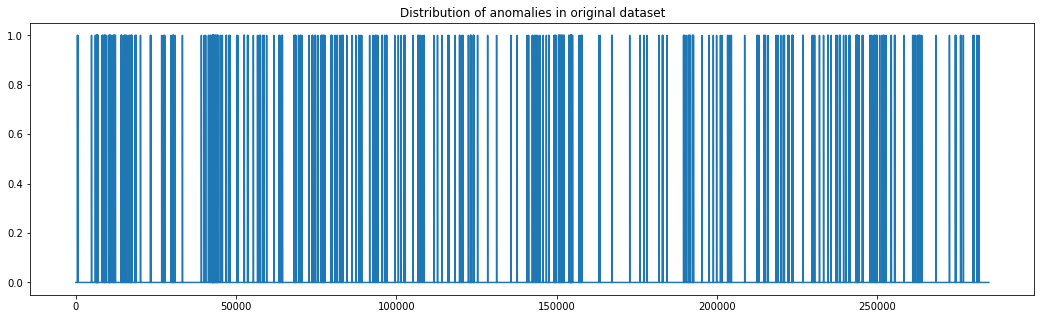

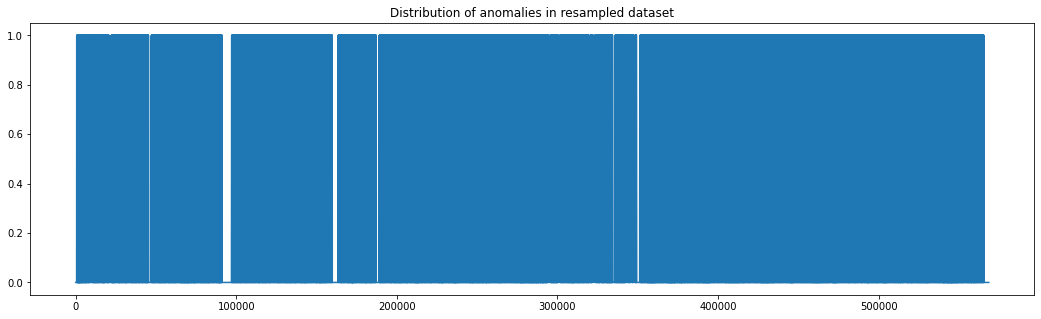

In [80]:
# Distribution of anomalies in original versus resampled
plt.figure(figsize=(18,5))
plt.plot(df['Class'])
plt.title('Distribution of anomalies in original dataset')

plt.figure(figsize=(18,5))
plt.plot(df_adasyn['Class'])
plt.title('Distribution of anomalies in resampled dataset')

plt.show()

In [81]:
# Normal vs Anomaly 
df_train_adasyn['attack'].value_counts()

1    208002
0    190027
Name: attack, dtype: int64

In [82]:
# Normal vs Anomaly 
df_test_adasyn['attack'].value_counts()

0    94288
1    76296
Name: attack, dtype: int64

# Compile anomaly percentage

In [83]:
# Convert dictionary to dataframe
col_names = ['dataset', 'changed', 'changed percent', 'train normal', 'train anomaly', 'test normal', 'test anomaly']
df_summary = pd.DataFrame(summary, columns=col_names)
df_summary.insert(0, 's/n', [i+1 for i in range(len(df_summary))])
df_summary['test_anom %'] = round(df_summary['test anomaly'] / (df_summary['test anomaly'] + df_summary['test normal'])*100, 4)
df_summary.to_csv('summary.csv', index=False)
df_summary

,s/n,dataset,changed,changed percent,train normal,train anomaly,test normal,test anomaly,test_anom %
0,1,all,0,0.0%,198981,384,85334,108,0.1264
1,2,all_s,0,0.0%,198981,384,85334,108,0.1264
2,3,pca,0,0.0%,198981,384,85334,108,0.1264
3,4,pca_s,0,0.0%,198981,384,85334,108,0.1264
4,5,first,-160214,-56.25%,89641,204,34708,40,0.1151
5,6,first_s,-160214,-56.25%,89641,204,34708,40,0.1151
6,7,last,-160214,-56.25%,89645,200,34702,46,0.1324
7,8,last_s,-160214,-56.25%,89645,200,34702,46,0.1324
8,9,anomaly,-160214,-56.25%,89484,361,34641,107,0.3079
9,10,anomaly_s,-160214,-56.25%,89484,361,34641,107,0.3079


In [5]:
df_train_adasyn_1_s, df_test_adasyn_1_s, df_adasyn_1_s, summary_adasyn_1_s = over_sample(df, 'adasyn_1_s', 1)

Number of synthetic samples added        : 2207
Percentage added                         : 0.77%


In [6]:
summary_adasyn_1_s

['adasyn_1_s', 2207, '0.77%', 198846, 2064, 85469, 635]

In [7]:
635 / (85469 + 635)

0.007374802564340797